In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def load_data(dataset_name="CIFAR10", batch_size=64, shuffle=True, train=True, custom_data_dir=None):
    """
    Load a dataset based on the specified name. Supports CIFAR-10, CIFAR-100, MNIST, and custom datasets.
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    if dataset_name == "CIFAR10":
        dataset = datasets.CIFAR10(root='./data', train=train, download=True, transform=transform)
    elif dataset_name == "CIFAR100":
        dataset = datasets.CIFAR100(root='./data', train=train, download=True, transform=transform)
    elif dataset_name == "MNIST":
        dataset = datasets.MNIST(root='./data', train=train, download=True, transform=transform)
    elif dataset_name == "Custom" and custom_data_dir:
        dataset = datasets.ImageFolder(root=os.path.join(custom_data_dir, 'train' if train else 'test'),
                                       transform=transform)
    else:
        raise ValueError(f"Unsupported dataset: {dataset_name}")

    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return data_loader

def compute_metrics(labels, predictions):
    """
    Compute precision, recall, and F1-score.
    """
    precision = precision_score(labels, predictions, average='weighted', zero_division=0)
    recall = recall_score(labels, predictions, average='weighted', zero_division=0)
    f1 = f1_score(labels, predictions, average='weighted', zero_division=0)
    return precision, recall, f1

def plot_metrics_heatmap(epoch_metrics, epochs):
    """
    Plot a heatmap based on the metrics (Accuracy, Precision, Recall, F1 Score, Loss) for each epoch.
    """
    # metrics_data = np.array([epoch_metrics['accuracy'], epoch_metrics['precision'], 
    #                          epoch_metrics['recall'], epoch_metrics['f1'], epoch_metrics['loss']])
    # metric_labels = ["Accuracy", "Precision", "Recall", "F1 Score", "Loss"]

    metrics_data = np.array([epoch_metrics['accuracy'], epoch_metrics['precision'], 
                             epoch_metrics['recall'], epoch_metrics['f1']])
    metric_labels = ["Accuracy", "Precision", "Recall", "F1 Score"]

    plt.figure(figsize=(8, 6))
    sns.heatmap(metrics_data, annot=True, fmt=".4f", cmap="YlGnBu", xticklabels=epochs, yticklabels=metric_labels)
    plt.title("Model Performance Metrics Heatmap")
    plt.xlabel("Epochs")
    plt.ylabel("Metrics")
    plt.show()

def train_mobilenet(data_loader, model, criterion, optimizer, epochs=1):
    # Ensure the model is on the CPU
    model = model.to('cpu')

    correct = 0
    total = 0
    running_loss = 0.0
    all_labels = []
    all_preds = []

    epoch_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'loss': []}
    
    for epoch in range(epochs):
        for inputs, labels in data_loader:
            inputs, labels = inputs.to('cpu'), labels.to('cpu')

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Accuracy calculation
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()

            # Collect predictions and labels for metric computation
            all_labels.extend(labels.numpy())
            all_preds.extend(predicted.numpy())

        accuracy = correct / total
        precision, recall, f1 = compute_metrics(all_labels, all_preds)
        avg_loss = running_loss / len(data_loader)

        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
        
        # Store metrics
        epoch_metrics['accuracy'].append(accuracy)
        epoch_metrics['precision'].append(precision)
        epoch_metrics['recall'].append(recall)
        epoch_metrics['f1'].append(f1)
        epoch_metrics['loss'].append(avg_loss)

    return epoch_metrics

def main(dataset, model_file, batch_size, shuffle, train, epochs, custom_data_dir):
    # Load a pre-trained global model (MobileNetV2) or from an external file
    model = models.mobilenet_v2(weights=None)  # Initialize MobileNetV2 without pre-trained weights
    if os.path.exists(model_file):
        print(f"Loading model from {model_file}")
        model.load_state_dict(torch.load(model_file, map_location=torch.device('cpu')))  # Load model from external file
    else:
        print(f"Model file {model_file} not found.")
        return

    # Load the dataset based on user input
    data_loader = load_data(dataset_name=dataset, batch_size=batch_size, shuffle=shuffle, train=train, custom_data_dir=custom_data_dir)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    # Train locally on client data
    epoch_metrics = train_mobilenet(data_loader, model, criterion, optimizer, epochs=epochs)

    # Plot the heatmap of metrics over epochs
    plot_metrics_heatmap(epoch_metrics, list(range(1, epochs + 1)))

    # Save the locally trained model (on CPU)
    torch.save(model.state_dict(), "./res/client_trained_model.pth")

    # Save the performance metrics
    with open("./res/client_metrics.txt", "w") as f:
        f.write(f"Accuracy: {epoch_metrics['accuracy'][-1]:.4f}\n")
        f.write(f"Precision: {epoch_metrics['precision'][-1]:.4f}\n")
        f.write(f"Recall: {epoch_metrics['recall'][-1]:.4f}\n")
        f.write(f"F1 Score: {epoch_metrics['f1'][-1]:.4f}\n")
        f.write(f"Loss: {epoch_metrics['loss'][-1]:.4f}\n")

Loading model from ./model/MobileNetV2.pth
Files already downloaded and verified
Epoch [1/10], Loss: 1.4227, Accuracy: 0.5788, Precision: 0.5839, Recall: 0.5788, F1 Score: 0.5812
Epoch [2/10], Loss: 2.2131, Accuracy: 0.6541, Precision: 0.6566, Recall: 0.6541, F1 Score: 0.6553
Epoch [3/10], Loss: 2.8769, Accuracy: 0.6932, Precision: 0.6947, Recall: 0.6932, F1 Score: 0.6939
Epoch [4/10], Loss: 3.4546, Accuracy: 0.7202, Precision: 0.7212, Recall: 0.7202, F1 Score: 0.7207
Epoch [5/10], Loss: 3.9611, Accuracy: 0.7411, Precision: 0.7418, Recall: 0.7411, F1 Score: 0.7414
Epoch [6/10], Loss: 4.4142, Accuracy: 0.7578, Precision: 0.7583, Recall: 0.7578, F1 Score: 0.7580
Epoch [7/10], Loss: 4.8329, Accuracy: 0.7713, Precision: 0.7717, Recall: 0.7713, F1 Score: 0.7714
Epoch [8/10], Loss: 5.2430, Accuracy: 0.7819, Precision: 0.7822, Recall: 0.7819, F1 Score: 0.7820
Epoch [9/10], Loss: 5.5958, Accuracy: 0.7923, Precision: 0.7926, Recall: 0.7923, F1 Score: 0.7924
Epoch [10/10], Loss: 5.9024, Accuracy

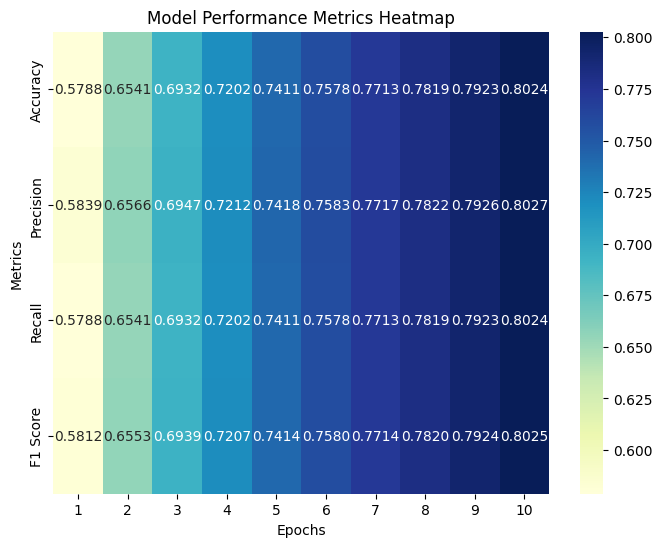

In [12]:
# import argparse
if __name__ == "__main__":
    dataset="CIFAR10"
    model = './model/MobileNetV2.pth'
    batch_size = 64
    shuffle = True
    train = True
    epochs = 10
    custom_data_dir = './data/'
    # parser = argparse.ArgumentParser()
    # parser.add_argument("--dataset", type=str, default="CIFAR10", help="Dataset to use: CIFAR10, CIFAR100, MNIST, or Custom")
    # parser.add_argument("--model", type=str, required=True, help="Path to global model file")
    # parser.add_argument("--batch_size", type=int, default=64, help="Batch size for the data loader")
    # parser.add_argument("--shuffle", type=bool, default=True, help="Whether to shuffle the dataset")
    # parser.add_argument("--train", type=bool, default=True, help="Load training or test set")
    # parser.add_argument("--epochs", type=int, default=5, help="Number of training epochs")
    # parser.add_argument("--custom_data_dir", type=str, default=None, help="Path to the custom dataset folder")
    # args = parser.parse_args()

    main(dataset, model, batch_size, shuffle, train, epochs, custom_data_dir)
